In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

here = "/project/vitelli/dsseara/schelling/jcolen/sociohydro/nonlinear_simulations"
os.chdir(here)
data_dir = "/project2/vitelli/dsseara/schelling/2024-03-26_MCPhaseDiagram/data"

cuda:0


Predicting using validation folder km-0.00_kp-0.56
0.0 4880.0 (489,)
Loaded state dict from file


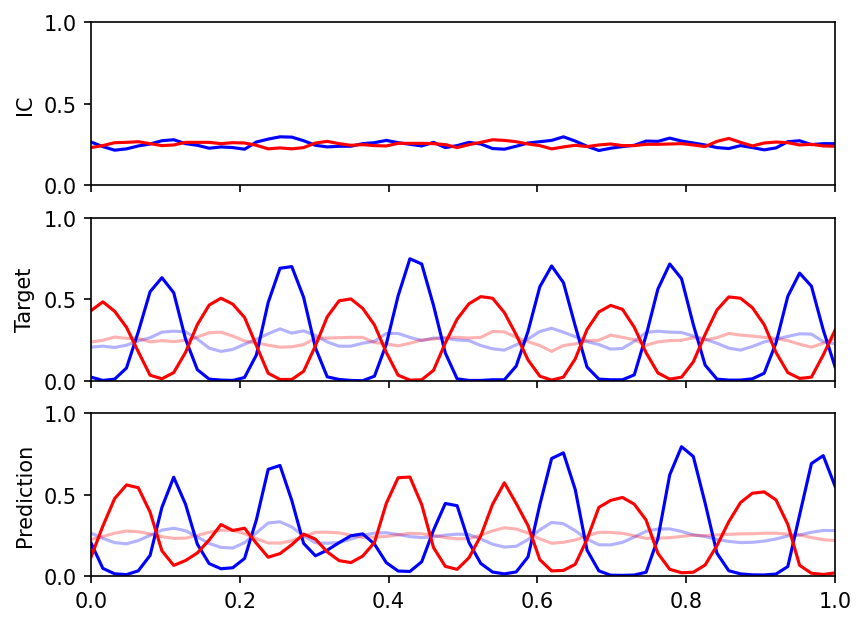

In [3]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting

device = torch.device('cuda:0')

model_path = 'models/SimulationForecasting_segregated_0'

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
folder = info['val_folder'][1]
print(f'Predicting using validation folder {os.path.basename(folder)}')
datafolder = os.path.join(data_dir, os.path.basename(folder))
ds = SimulationDataset(datafolder, seq_len=90)

# Load model
info = torch.load(f'{model_path}.ckpt')
model = SimulationForecasting().to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

sample = ds[3]

fig, ax = plt.subplots(3, 1, dpi=150, sharex=True, sharey=True)

ax[0].plot(ds.x, sample['ab'][0,0], color='blue')
ax[0].plot(ds.x, sample['ab'][0,1], color='red')
ax[0].set_ylabel('IC')

ax[1].plot(ds.x, sample['ab'][5,0], color='blue', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][5,1], color='red', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][40,0], color='blue')
ax[1].plot(ds.x, sample['ab'][40,1], color='red')
ax[1].set_ylabel('Target')

ab1 = model.simulate(sample['ab'][0:1].to(device), ds.seq_len)[0]
ab1 = ab1.detach().cpu().numpy()

ax[2].plot(ds.x, ab1[5,0], color='blue', alpha=0.3)
ax[2].plot(ds.x, ab1[5,1], color='red', alpha=0.3)
ax[2].plot(ds.x, ab1[40,0], color='blue')
ax[2].plot(ds.x, ab1[40,1], color='red')
ax[2].set_ylabel('Prediction')

ax[0].set(xlim=[0,1], ylim=[0,1])
plt.show()

## Calculate the saliencies using the validation dataset for each model

In [ ]:
from tqdm.auto import tqdm

def compute_saliency(model, ab):
    '''
    Make predictions of the time derivative for each time point in sample
    Compute saliency using those predictions
    model is a neural network whose forward function predicts the time derivative
    ab is a [T, C, L] shaped FloatTensor which is a time series of occupation fractions
    '''
    loc = torch.zeros(ab.shape[-1], dtype=ab.dtype, device=ab.device)
    G_S_shifted = []
    for tt in tqdm(range(ab.shape[0])):
        G_S = []
        inputs = ab[tt:tt+1].clone()
        inputs.requires_grad = True
        dt_ab = model(inputs)
        for xx in range(dt_ab.shape[2]):
            loc[:] = 0.
            loc[xx] = 1.
            grad = []
            for cc in range(dt_ab.shape[1]):
                grad.append(
                    torch.autograd.grad(dt_ab[0,cc], inputs, grad_outputs=loc, retain_graph=True)[0]
                )
            grad = torch.cat(grad, dim=0) # [C, C, L]
            G_S.append(grad.detach().cpu().numpy())
        
        center = dt_ab.shape[-1] // 2
        shifts = center - np.arange(dt_ab.shape[-1], dtype=int)
        G_S_shifted.append(np.asarray([np.roll(g, shift, axis=-1) for shift, g in zip(shifts, G_S)]))
    
    return np.array(G_S_shifted) #[T, L, C, C, L]

phases = [
    'segregated',
    'integrated',
    'migration1',
    'migration2',
]

for i, phase in enumerate(phases):
    model_path = f'models/SimulationForecasting_{phase}_{i}'

    # Load model
    info = torch.load(f'{model_path}.ckpt')
    model = SimulationForecasting().to(device)
    model.load_state_dict(info['state_dict'])
    model.eval();

    # Get validation set simulation
    with open(f'{model_path}_args.txt', 'r') as f:
        info = json.load(f)

    G_S_shifted = []

    for folder in np.random.choice(info['val_folder'], 5):
        ds = SimulationDataset(folder, seq_len=50)

        sample = ds[0]
        ab = sample['ab'].to(device)
        G_S_shifted.append(compute_saliency(model, ab))

    np.save(f'{model_path}_saliency.npy', np.stack(G_S_shifted))

IndexError: list index out of range

## Plot the saliencies

segregated
(16000, 2, 2, 64)
integrated
(16000, 2, 2, 64)
migration1
(16000, 2, 2, 64)
migration2
(16000, 2, 2, 64)


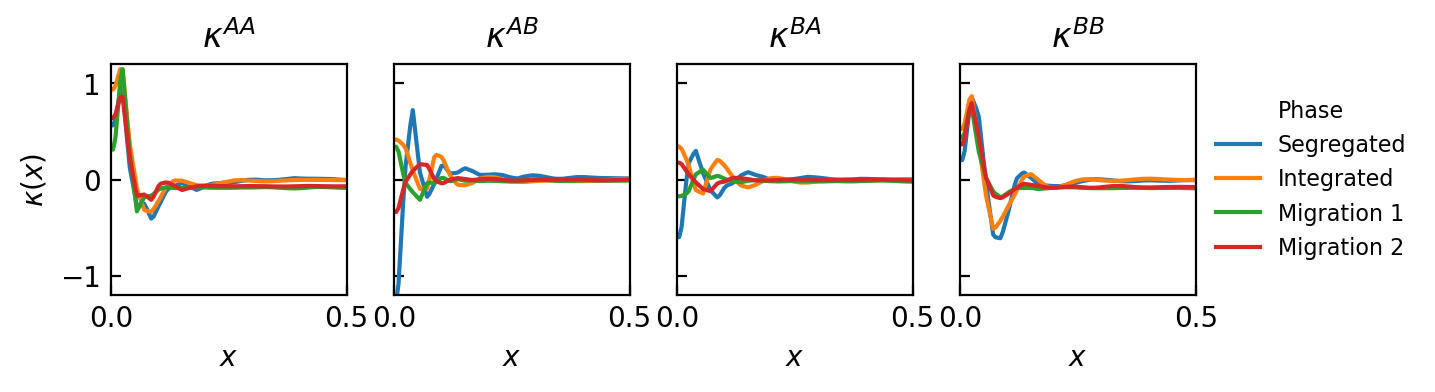

In [10]:
from scipy.interpolate import interp1d

xx = ds.x - ds.x.mean()
xmin = 0.
xmax = xx.max()
x_plot = np.linspace(xmin, xmax, 100)

labels = {
    'segregated': 'Segregated',
    'integrated': 'Integrated',
    'migration1': 'Migration 1',
    'migration2': 'Migration 2'
}

fig, ax = plt.subplots(1, 4, dpi=200, 
    figsize=(7, 1.5),
    sharex=True, sharey=True)

for i, phase in enumerate(labels):
    print(phase)
    G_S_shifted = np.load(f'models/SimulationForecasting_{phase}_{i}_saliency.npy', 
                          mmap_mode='r')
    G_S_shifted = G_S_shifted.reshape([-1, 2, 2, xx.shape[0]])

    print(G_S_shifted.shape)

    for ii in range(2):
        for jj in range(2):
            Gr = np.mean(G_S_shifted[:, ii, jj], axis=0)
            Gr = interp1d(xx, Gr + Gr[::-1])
            Gr = Gr(x_plot)
            ax[2*ii+jj].plot(x_plot, Gr, label=labels[phase])

for a in ax:
    a.set(
        xlim=[xmin, xmax],
        xlabel='$x$',
        xticks=[0, 0.5],
        ylim=[-1.2, 1.2],
        yticks=[-1, 0, 1]
    )
    a.tick_params(which='both', direction='in')

ax[0].set_ylabel(r'$\kappa(x)$')
ax[0].set_title(r'$\kappa^{AA}$')
ax[1].set_title(r'$\kappa^{AB}$')
ax[2].set_title(r'$\kappa^{BA}$')
ax[3].set_title(r'$\kappa^{BB}$')
ax[3].legend(title='Phase', loc='center left', bbox_to_anchor=[1, 0.5], 
             framealpha=0., fontsize=8, title_fontsize=8)

plt.show()
if input() == "save":
    fig.savefig('Figures/SaliencySimulations.svg', bbox_inches='tight')

segregated
(16000, 2, 2, 64)
integrated
(16000, 2, 2, 64)
migration1
(16000, 2, 2, 64)
migration2
(16000, 2, 2, 64)


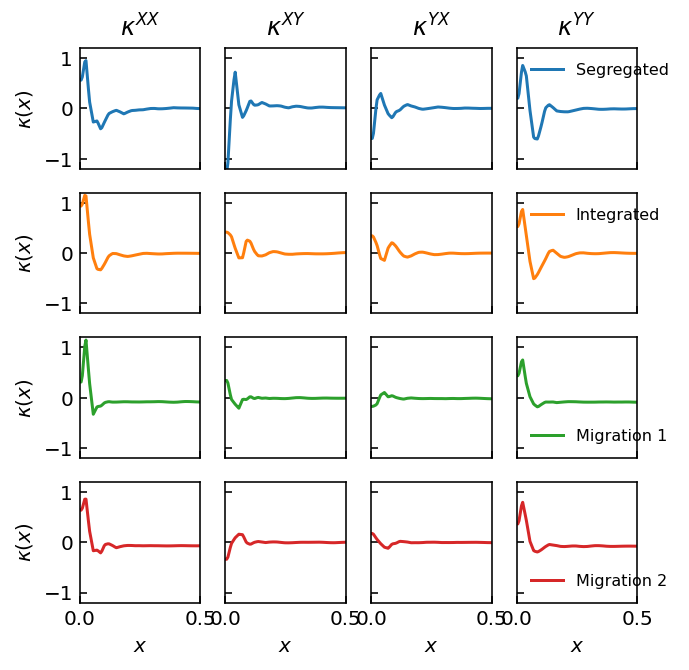

In [12]:
from scipy.interpolate import interp1d

xx = ds.x - ds.x.mean()
xmin = 0.
xmax = xx.max()
x_plot = np.linspace(xmin, xmax, 100)

labels = {
    'segregated': 'Segregated',
    'integrated': 'Integrated',
    'migration1': 'Migration 1',
    'migration2': 'Migration 2'
}

fig, ax = plt.subplots(4, 4, dpi=144, 
    figsize=(5, 5),
    sharex=True, sharey=True)

for i, phase in enumerate(labels):
    print(phase)
    G_S_shifted = np.load(f'models/SimulationForecasting_{phase}_{i}_saliency.npy', 
                          mmap_mode='r')
    G_S_shifted = G_S_shifted.reshape([-1, 2, 2, xx.shape[0]])

    print(G_S_shifted.shape)

    for ii in range(2):
        for jj in range(2):
            Gr = np.mean(G_S_shifted[:, ii, jj], axis=0)
            Gr = interp1d(xx, Gr + Gr[::-1])
            Gr = Gr(x_plot)
            ax[i, 2*ii+jj].plot(x_plot, Gr, label=labels[phase], color=f'C{i}')

for a in ax.ravel():
    a.set(
        xlim=[xmin, xmax],
        # xlabel='$x$',
        xticks=[0, 0.5],
        ylim=[-1.2, 1.2],
        yticks=[-1, 0, 1]
    )
    a.tick_params(which='both', direction='in')
    a.set_aspect(np.ptp(a.get_xlim())/np.ptp(a.get_ylim()))

ax[0, 0].set_title(r'$\kappa^{XX}$')
ax[0, 1].set_title(r'$\kappa^{XY}$')
ax[0, 2].set_title(r'$\kappa^{YX}$')
ax[0, 3].set_title(r'$\kappa^{YY}$')
for a in ax:
    a[-1].legend(fontsize=8, framealpha=0)
    a[0].set_ylabel(r'$\kappa(x)$')
    # title='Phase', loc='center left', bbox_to_anchor=[1, 0.5], 
    #             framealpha=0., fontsize=8, title_fontsize=8)

for a in ax[-1, :]:
    a.set_xlabel('$x$')

if input() == "save":
    fig.savefig('Figures/SaliencySimulations_separated.pdf', bbox_inches='tight')

plt.show()